In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = [
    "api_data_aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_0_500000.csv",
    "api_data_aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_500000_1000000.csv",
    "api_data_aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_1000000_1500000.csv",
    "api_data_aadhar_biometric/api_data_aadhar_biometric/api_data_aadhar_biometric_1500000_1861108.csv"
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

In [3]:
df.shape

(1861108, 6)

In [4]:
df.to_csv("aadhar_biometric_full.csv", index=False)

In [5]:
df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [6]:
df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [7]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df["total"] = df["bio_age_5_17"] + df["bio_age_17_"]
df["youth_ratio"] = df["bio_age_5_17"] / df["total"].clip(lower=1)


In [8]:
df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,total,youth_ratio
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,857,0.326721
1,2025-03-01,Bihar,Madhepura,852121,144,369,513,0.280702
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091,1734,0.370819
3,2025-03-01,Bihar,Bhojpur,802158,256,980,1236,0.207120
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,1086,0.249540


In [9]:
features = df.groupby("pincode").agg(
    mean_total = ("total", "mean"),
    std_total = ("total", "std"),
    max_total = ("total", "max"),
    mean_youth = ("youth_ratio", "mean"),
    std_youth = ("youth_ratio", "std"),
    days = ("date", "nunique")
).fillna(0)


In [10]:
features

,mean_total,std_total,max_total,mean_youth,std_youth,days
pincode,,,,,,
110001,18.493243,60.255183,386,0.351539,0.308162,82
110002,79.953488,207.828487,1227,0.415956,0.147360,82
110003,39.818750,135.407927,911,0.289630,0.274421,80
110004,2.500000,1.990833,10,0.744048,0.410067,37
110005,131.642857,391.139443,2341,0.476191,0.135231,82
...,...,...,...,...,...,...
855114,117.892857,294.067692,1591,0.310868,0.122315,77
855115,103.894444,282.323866,1898,0.347032,0.198795,85
855116,158.586207,333.054767,1681,0.353926,0.181438,80


In [11]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=300, random_state=42)
model.fit(features)

raw = -model.decision_function(features)


In [12]:
s = np.sort(raw)
s

array([-0.13748888, -0.13743736, -0.13739035, ...,  0.27102634,
        0.27191136,  0.27238902], shape=(19707,))

In [13]:
import numpy as np

dx = np.diff(s)
ddx = np.diff(dx)

knee = np.argmax(ddx)


In [14]:
threshold = s[knee]

threshold

np.float64(0.24264448932099358)

In [15]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=300,
    contamination=0.242,
    random_state=42
)

model.fit(features)

scores = -model.decision_function(features)


In [16]:
fraud_prob = (scores - scores.min()) / (scores.max() - scores.min())
features["fraud_probability"] = fraud_prob


In [17]:
features = features.sort_values("fraud_probability", ascending=False)

In [18]:
features.head()

,mean_total,std_total,max_total,mean_youth,std_youth,days,fraud_probability
pincode,,,,,,,
244001,838.293478,2057.513513,11612,0.593956,0.107594,87,1.000000
132103,554.885057,1430.986612,9154,0.420816,0.062901,84,0.998835
110062,606.831325,1949.064033,13381,0.455655,0.069225,81,0.996675
110086,752.159091,2113.682725,12805,0.439825,0.097860,83,0.988756
110094,291.722222,1183.897904,11987,0.206155,0.251056,88,0.987079


In [19]:
location_df = df[["pincode", "state", "district"]].drop_duplicates()

In [20]:
location_df.head()

,pincode,state,district
0,123029,Haryana,Mahendragarh
1,852121,Bihar,Madhepura
2,185101,Jammu and Kashmir,Punch
3,802158,Bihar,Bhojpur
4,625514,Tamil Nadu,Madurai


In [21]:
features.index = features.index.astype(int)
location_df["pincode"] = location_df["pincode"].astype(int)

In [22]:
features = features.reset_index().merge(
    location_df,
    on="pincode",
    how="left"
).set_index("pincode")

features.head()

,mean_total,std_total,max_total,mean_youth,std_youth,days,fraud_probability,state,district
pincode,,,,,,,,,
244001,838.293478,2057.513513,11612,0.593956,0.107594,87,1.000000,Uttar Pradesh,Moradabad
244001,838.293478,2057.513513,11612,0.593956,0.107594,87,1.000000,Uttar Pradesh,Sambhal
132103,554.885057,1430.986612,9154,0.420816,0.062901,84,0.998835,Haryana,Panipat
110062,606.831325,1949.064033,13381,0.455655,0.069225,81,0.996675,Delhi,South Delhi
110086,752.159091,2113.682725,12805,0.439825,0.097860,83,0.988756,Delhi,North West Delhi


In [23]:
features["district"] = features.groupby("pincode")["district"] \
    .transform(lambda x: ", ".join(sorted(x.unique())))

features = features.drop_duplicates()


In [24]:
features.head()

,mean_total,std_total,max_total,mean_youth,std_youth,days,fraud_probability,state,district
pincode,,,,,,,,,
244001,838.293478,2057.513513,11612,0.593956,0.107594,87,1.000000,Uttar Pradesh,"Moradabad, Sambhal"
132103,554.885057,1430.986612,9154,0.420816,0.062901,84,0.998835,Haryana,Panipat
110062,606.831325,1949.064033,13381,0.455655,0.069225,81,0.996675,Delhi,South Delhi
110086,752.159091,2113.682725,12805,0.439825,0.097860,83,0.988756,Delhi,North West Delhi
110094,291.722222,1183.897904,11987,0.206155,0.251056,88,0.987079,Delhi,"East Delhi, North East, North East Delhi, Nort..."


In [ ]:
# features.to_csv("Fraud_Probability_pincodes.csv")

## Top States by Avg. Fraud Probability

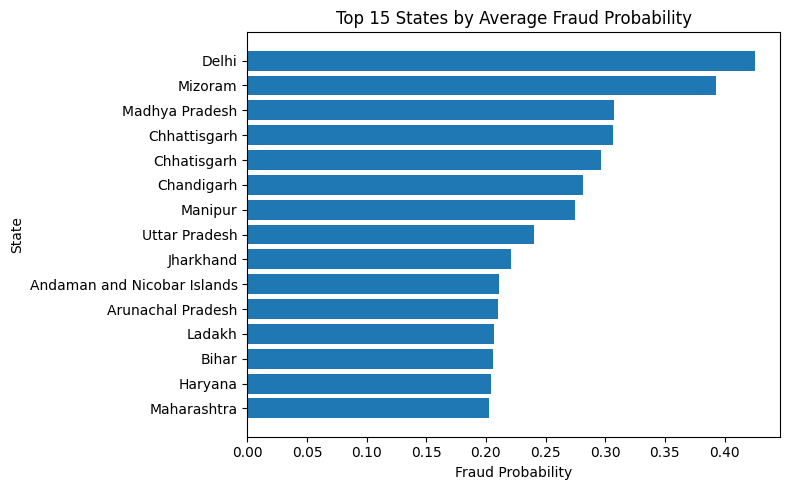

In [26]:
top_n = 15

state_fraud = (
    features.groupby("state")["fraud_probability"]
    .mean()
    .sort_values(ascending=False)
    .head(top_n)
)

plt.figure(figsize=(8,5))
plt.barh(state_fraud.index[::-1], state_fraud.values[::-1])
plt.title(f"Top {top_n} States by Average Fraud Probability")
plt.xlabel("Fraud Probability")
plt.ylabel("State")
plt.tight_layout()
plt.show()

## Distribution of Fraud Probability

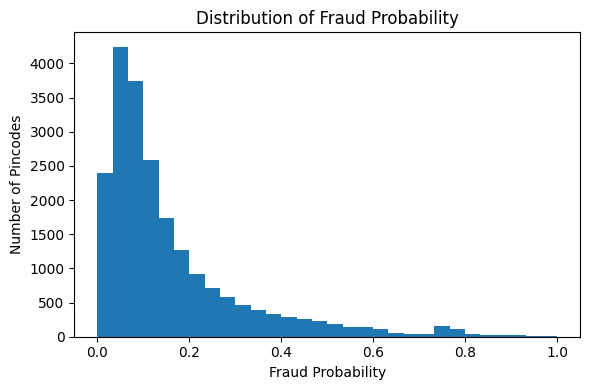

In [27]:
plt.figure(figsize=(6,4))
plt.hist(features["fraud_probability"], bins=30)
plt.xlabel("Fraud Probability")
plt.ylabel("Number of Pincodes")
plt.title("Distribution of Fraud Probability")
plt.tight_layout()
plt.show()


## Fraud v/s Transaction Volatility

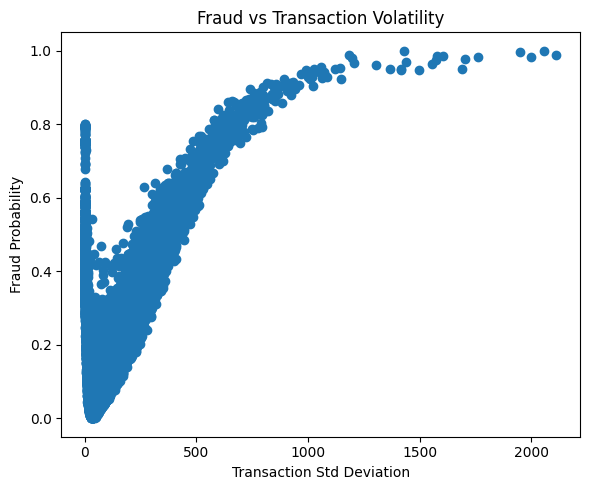

In [28]:
plt.figure(figsize=(6,5))
plt.scatter(features["std_total"], features["fraud_probability"])
plt.xlabel("Transaction Std Deviation")
plt.ylabel("Fraud Probability")
plt.title("Fraud vs Transaction Volatility")
plt.tight_layout()
plt.show()


## Fraud v/s Youth Share

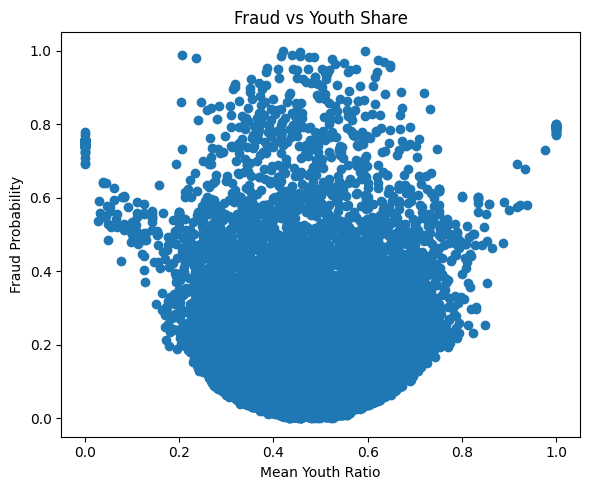

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(features["mean_youth"], features["fraud_probability"])
plt.xlabel("Mean Youth Ratio")
plt.ylabel("Fraud Probability")
plt.title("Fraud vs Youth Share")
plt.tight_layout()
plt.show()


## Active Days Distribution

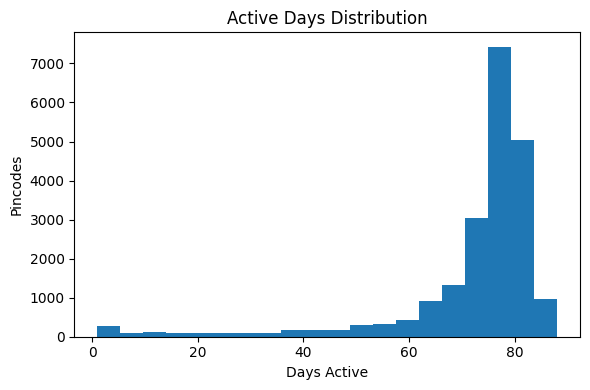

In [30]:
plt.figure(figsize=(6,4))
plt.hist(features["days"], bins=20)
plt.xlabel("Days Active")
plt.ylabel("Pincodes")
plt.title("Active Days Distribution")
plt.tight_layout()
plt.show()


## Feature Correlation Matrix

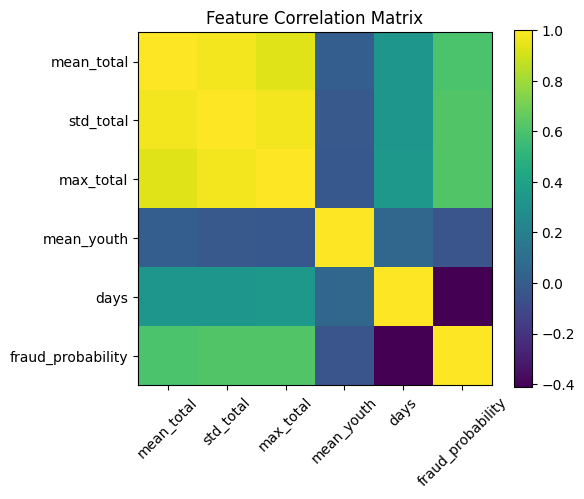

In [31]:
corr = features[
    ["mean_total", "std_total", "max_total",
     "mean_youth", "days", "fraud_probability"]
].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr)
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


## Fraud Risk Tier Distribution

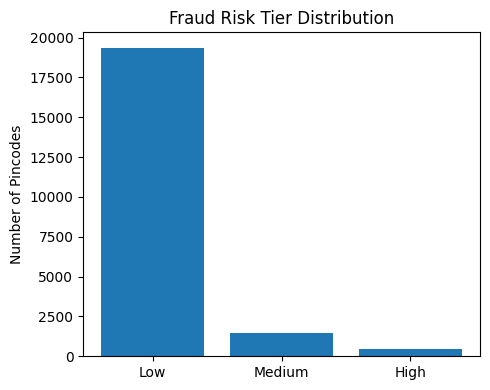

In [32]:
features["risk_level"] = pd.cut(
    features["fraud_probability"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

risk_counts = features["risk_level"].value_counts()

plt.figure(figsize=(5,4))
plt.bar(risk_counts.index, risk_counts.values)
plt.title("Fraud Risk Tier Distribution")
plt.ylabel("Number of Pincodes")
plt.tight_layout()
plt.show()


## Normal vs Fraudulent Behaviour Zones

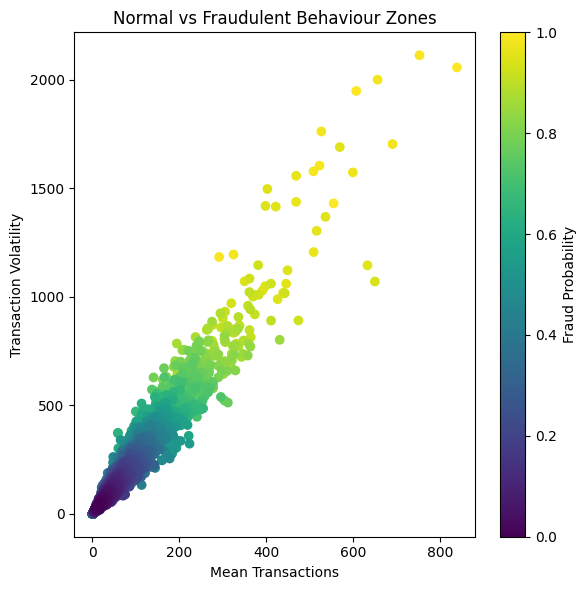

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(
    features["mean_total"],
    features["std_total"],
    c=features["fraud_probability"]
)
plt.xlabel("Mean Transactions")
plt.ylabel("Transaction Volatility")
plt.title("Normal vs Fraudulent Behaviour Zones")
plt.colorbar(label="Fraud Probability")
plt.tight_layout()
plt.show()


## Fraud Concentration (Pareto Effect)
Pareto Principle (80–20 Rule):

A small fraction of causes is responsible for a large fraction of outcomes.

A small % of pincodes contribute to most of the fraud risk.
Identifying and targeting these few high-impact regions gives maximum impact with minimal effort.

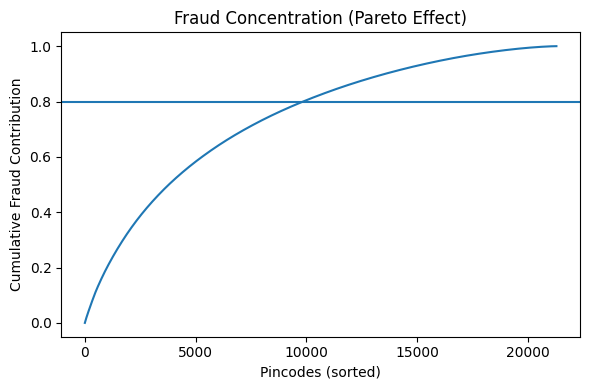

In [34]:
sorted_fp = features.sort_values("fraud_probability", ascending=False)
cum_fp = sorted_fp["fraud_probability"].cumsum() / sorted_fp["fraud_probability"].sum()

plt.figure(figsize=(6,4))
plt.plot(cum_fp.values)
plt.axhline(0.8)
plt.xlabel("Pincodes (sorted)")
plt.ylabel("Cumulative Fraud Contribution")
plt.title("Fraud Concentration (Pareto Effect)")
plt.tight_layout()
plt.show()


## Fraud Behaviour Clusters

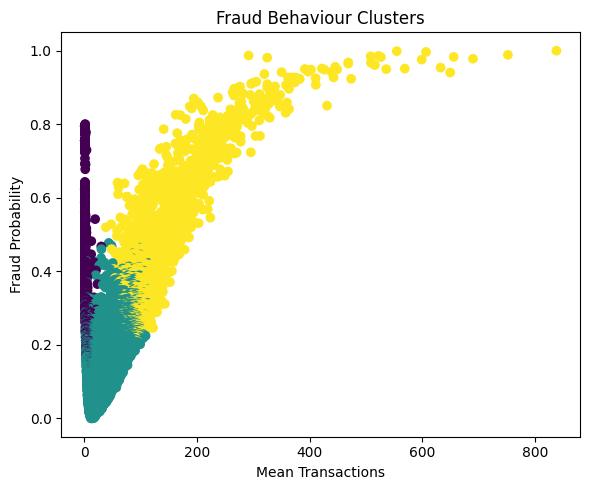

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = features[[
    "mean_total", "std_total", "max_total",
    "mean_youth", "days"
]]

X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
features["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(
    features["mean_total"],
    features["fraud_probability"],
    c=features["cluster"]
)
plt.xlabel("Mean Transactions")
plt.ylabel("Fraud Probability")
plt.title("Fraud Behaviour Clusters")
plt.tight_layout()
plt.show()


## High Risk Pincodes

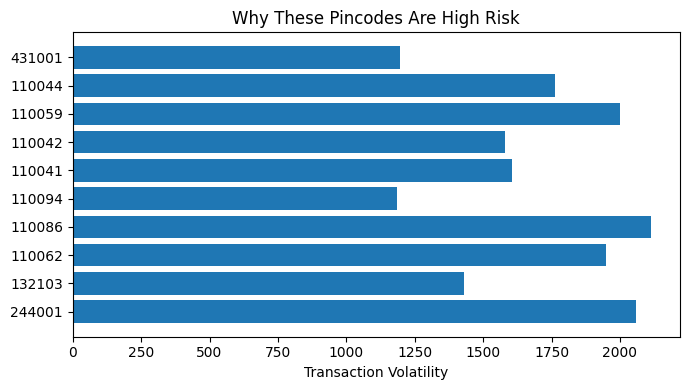

In [36]:
top = features.sort_values("fraud_probability", ascending=False).head(10)

plt.figure(figsize=(7,4))
plt.barh(top.index.astype(str), top["std_total"])
plt.xlabel("Transaction Volatility")
plt.title("Why These Pincodes Are High Risk")
plt.tight_layout()
plt.show()


## Ambiguity in Aadhaar Data

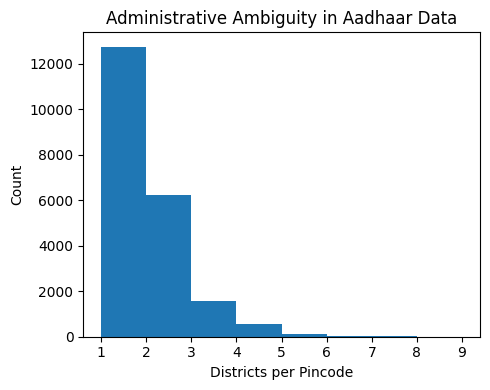

In [37]:
district_counts = features["district"].str.count(",") + 1

plt.figure(figsize=(5,4))
plt.hist(district_counts, bins=range(1, district_counts.max()+2))
plt.xlabel("Districts per Pincode")
plt.ylabel("Count")
plt.title("Administrative Ambiguity in Aadhaar Data")
plt.tight_layout()
plt.show()


## Administrative Ambiguity v/s Fraud Risk

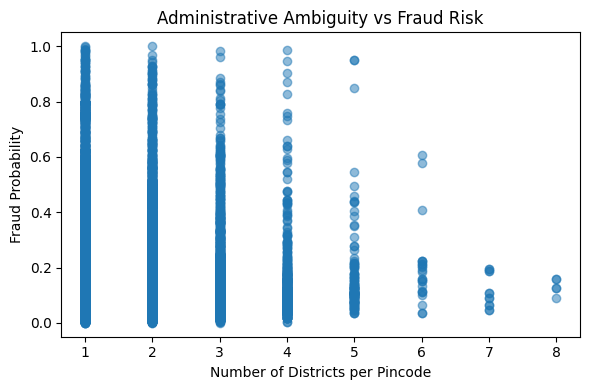

In [38]:
plt.figure(figsize=(6,4))
plt.scatter(district_counts, features["fraud_probability"], alpha=0.5)
plt.xlabel("Number of Districts per Pincode")
plt.ylabel("Fraud Probability")
plt.title("Administrative Ambiguity vs Fraud Risk")
plt.tight_layout()
plt.show()
